In [3]:
import pandas as pd
import numpy as np
import ipaddress
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
fraud_df = pd.read_csv(r"C://Users//Hiwi//Documents//week8&9//Fraud_Data.csv")
ip_df = pd.read_csv(r"C://Users//Hiwi//Documents//week8&9//IpAddress_to_Country.csv")
credit_df = pd.read_csv(r"C://Users//Hiwi//Documents//week8&9//creditcard.csv")

In [5]:
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

In [6]:
fraud_df.fillna({'browser': fraud_df['browser'].mode()[0]}, inplace=True)
fraud_df.dropna(inplace=True)

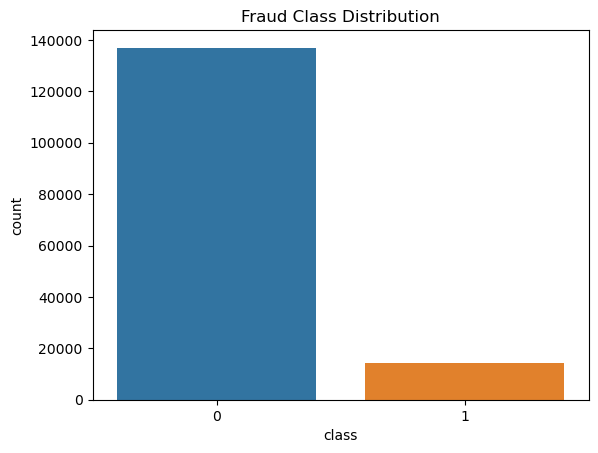

In [7]:
sns.countplot(x='class', data=fraud_df)
plt.title("Fraud Class Distribution")
plt.show()
# --- Feature Engineering: Time Features ---
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds() / 3600

In [8]:
print(fraud_df.columns.tolist())

['user_id', 'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class', 'hour_of_day', 'day_of_week', 'time_since_signup']


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import f1_score, precision_recall_curve, confusion_matrix, auc
# 1. Define features and target
X = fraud_df.drop(columns=['class', 'signup_time', 'purchase_time'])
y = fraud_df['class']


In [19]:
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("\nX_train sample:\n", X_train.head())
print("\ny_train sample:\n", y_train.head())

X_train shape: (120889, 11)
X_test shape: (30223, 11)
y_train shape: (120889,)
y_test shape: (30223,)

X_train sample:
         user_id  purchase_value      device_id  source  browser sex  age  \
50481    306367              40  XVRUVPTHWQASG     Ads   Chrome   F   36   
95673    349918              25  YEIHKJKVXOTOG  Direct       IE   M   31   
139063   252150              47  TUIGQGWCACDLN     Ads       IE   M   41   
28313    127539              86  DSHXPRGHOCLEK  Direct  FireFox   M   42   
123477   257348              40  NYFGHBQGURDIN     SEO   Safari   M   42   

          ip_address  hour_of_day  day_of_week  time_since_signup  
50481   7.195639e+08            5            3         132.950833  
95673   3.796264e+09           16            1        2474.670278  
139063  4.106204e+09            9            1        2214.139444  
28313   6.139430e+08           20            3         852.813611  
123477  1.763565e+08           12            0         210.768889  

y_train sample

In [25]:
# 5. Logistic Regression Pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

logreg_pipeline.fit(X_train, y_train)
print(" Model training completed.")
y_pred_logreg = logreg_pipeline.predict(X_test)
print("\n Predicted class labels (first 10):\n", y_pred_logreg[:10])

# Predict class probabilities
y_proba_logreg = logreg_pipeline.predict_proba(X_test)[:, 1]
print("\n Predicted class probabilities for class 1 (first 10):\n", y_proba_logreg[:10])


 Model training completed.

 Predicted class labels (first 10):
 [0 0 0 0 0 0 0 0 0 0]

 Predicted class probabilities for class 1 (first 10):
 [0.02366252 0.02036224 0.07513917 0.04240401 0.03017153 0.15473579
 0.04798094 0.02235402 0.10342737 0.02636404]


In [26]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
# 6. XGBoost Pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])
xgb_pipeline.fit(X_train, y_train)
print(" XGBoost model training completed.")
y_pred_xgb = xgb_pipeline.predict(X_test)
print("\n XGBoost predicted class labels (first 10):\n", y_pred_xgb[:10])
y_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]
print("\n XGBoost predicted class probabilities for class 1 (first 10):\n", y_proba_xgb[:10])


C:\Users\Hiwi\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:41:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 XGBoost model training completed.

 XGBoost predicted class labels (first 10):
 [0 0 0 0 0 0 0 0 0 0]

 XGBoost predicted class probabilities for class 1 (first 10):
 [0.02815171 0.04049708 0.02426099 0.04250879 0.0524574  0.0680775
 0.04378176 0.00702622 0.04544612 0.02709024]


In [27]:
# 7. Evaluation Function
def evaluate_model(y_test, y_pred, y_proba):
    f1 = f1_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    auc_pr = auc(recall, precision)
    cm = confusion_matrix(y_test, y_pred)

    print("F1 Score:", f1)
    print("AUC-PR:", auc_pr)
    print("Confusion Matrix:\n", cm)

In [28]:
# 8. Print Results
print("Logistic Regression Performance:")
evaluate_model(y_test, y_pred_logreg, y_proba_logreg)

print("\nXGBoost Performance:")
evaluate_model(y_test, y_pred_xgb, y_proba_xgb)

Logistic Regression Performance:
F1 Score: 0.564179104477612
AUC-PR: 0.602545588195774
Confusion Matrix:
 [[27337    56]
 [ 1696  1134]]

XGBoost Performance:
F1 Score: 0.6726497644155262
AUC-PR: 0.5966508683933794
Confusion Matrix:
 [[27265   128]
 [ 1331  1499]]


 99%|===================| 992/1000 [01:26<00:00]        

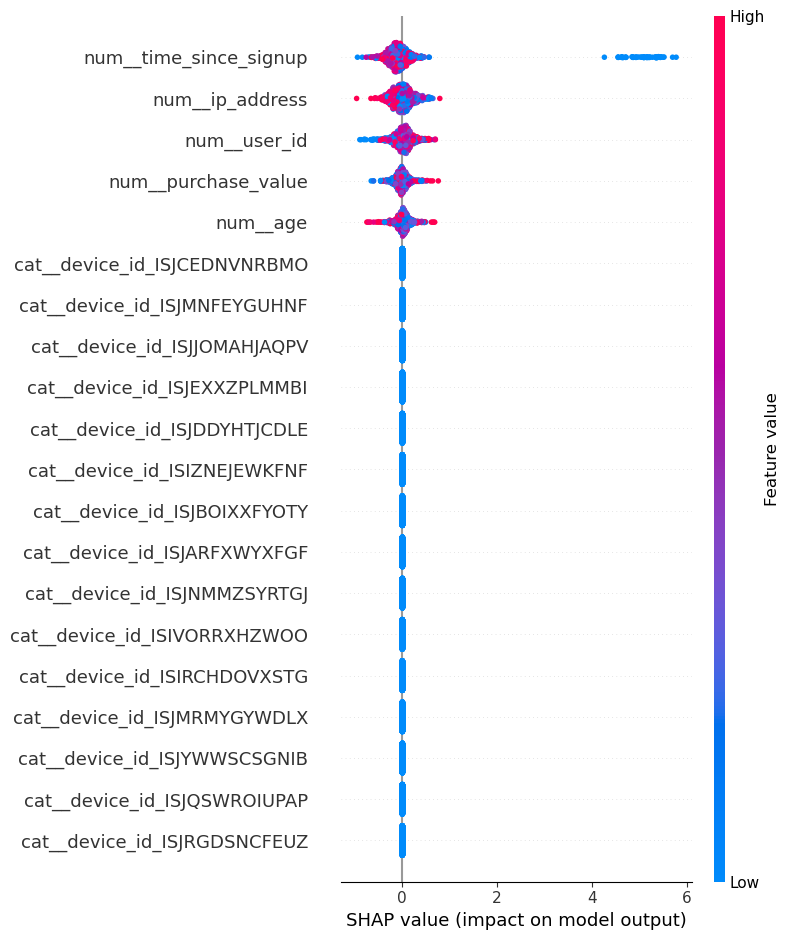

In [17]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# 1. Convert sparse matrix to dense (limit to 1000 rows for efficiency)
X_sample = X_test_transformed[:1000].toarray()

# 2. Initialize SHAP TreeExplainer with the trained XGBoost model
explainer = shap.Explainer(xgb_model, X_sample)

# 3. Compute SHAP values
shap_values = explainer(X_sample)
feature_names = preprocessor.get_feature_names_out()


# 4. Plot SHAP summary (global feature importance)
shap.summary_plot(shap_values, X_sample, feature_names=feature_names)
